# M45 Coursework
Liz Simpson, 
951428,
Due: Monday 19th April 2021
## Using AlexNet and ResNet to evaluate their effectiveness on classifying objects

In [ ]:
import numpy as np

#Train-validation-test split
from sklearn.model_selection import train_test_split

#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from keras.utils import to_categorical

#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#Alex Net Models
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

#Graphs 
import matplotlib.pyplot as plt

#Evaluation 
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#ResNet
import h5py
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History
from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

## Loading Data 

CIFAR-100 Dataset using fine labels that labels data into 100 classes and coarse dataset that categorises the data into 20 superclasses. All images are 32x32 w x h and have an RGB value. There are 50000 images in the train dataset and 10000 in the test dataset. 

In [35]:
images = np.load('trnImage.npy')
labels = np.load('trnLabel_coarse.npy')
labels_fine = np.load('trnLabel_fine.npy')

test_images = np.load('tstImage.npy')
test_labels = np.load('tstLabel_coarse.npy')
test_labels_fine = np.load('tstLabel_fine.npy')

print(f'Images Shape: {images.shape}')
print(f'Train Labels Coarse Shape: {labels.shape}')

Images Shape: (32, 32, 3, 50000)
Train Labels Coarse Shape: (50000,)


# 
# Alex Net Coarse
### Build the AlexNet with 11 layers 
Layers include convolutional2D layers, Activation layers using the ReLu and Softmax functions, BatchNormalisation and Max Pooling layers.

In [23]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(20))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 96)          384       
_________________________________________________________________
activation_9 (Activation)    (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_10 (Activation)   (None, 4, 4, 256)        

### Complie AlexNet

In [24]:
# Compiling the model
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

### Change input shapes on Coarse Dataset
Training Data needs shape ((35000, 32, 32, 3)
Training Labels need shape (35000, 100))

Use imagedataGenerators to generate enough data for the model from existing data.

In [36]:
x_train = np.transpose(images, (3, 0, 1, 2))
y_train = labels.reshape(50000, 1)

x_test = np.transpose(test_images, (3, 0, 1, 2))
y_test = test_labels

#Train-validation-test split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3)

#Since we have 20 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 20
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

((35000, 32, 32, 3), (35000, 100))
((15000, 32, 32, 3), (15000, 100))
((10000, 32, 32, 3), (10000, 20))


In [27]:
print(f'Images Shape: {train_images_reshaped.shape}')
print(f'Train Labels Coarse Shape: {test_images_reshaped.shape}')

Images Shape: (50000, 32, 32, 3)
Train Labels Coarse Shape: (10000, 32, 32, 3)


In [37]:
#Defining the parameters
batch_size= 100
epochs=100

# Train model

In [31]:
#Training the model
AlexNet.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size=batch_size), validation_steps = len(x_val)//batch_size, verbose=1)


Epoch 1/100
350/350 [==============================] - 156s 442ms/step - loss: 2.6588 - accuracy: 0.1843 - val_loss: 3.0741 - val_accuracy: 0.1523
Epoch 2/100
350/350 [==============================] - 159s 455ms/step - loss: 2.3056 - accuracy: 0.2861 - val_loss: 3.1576 - val_accuracy: 0.1925
Epoch 3/100
350/350 [==============================] - 161s 461ms/step - loss: 2.1845 - accuracy: 0.3224 - val_loss: 2.4502 - val_accuracy: 0.2684
Epoch 4/100
350/350 [==============================] - 154s 441ms/step - loss: 2.0883 - accuracy: 0.3517 - val_loss: 2.7001 - val_accuracy: 0.2463
Epoch 5/100
350/350 [==============================] - 147s 420ms/step - loss: 2.0153 - accuracy: 0.3740 - val_loss: 2.2482 - val_accuracy: 0.3184
Epoch 6/100
350/350 [==============================] - 148s 422ms/step - loss: 1.9406 - accuracy: 0.3971 - val_loss: 3.1157 - val_accuracy: 0.2049
Epoch 7/100
350/350 [==============================] - 148s 423ms/step - loss: 1.8967 - accuracy: 0.4132 - val_loss: 2

# Save and Load Models

In [32]:
AlexNet.save('alexNet_coarse')

INFO:tensorflow:Assets written to: alexNet_coarse\assets


In [50]:
history = keras.models.load_model('alexNet_coarse')
print(history)

# AlexNet Coarse Evaluation

In [44]:
print(AlexNet.predict(test_images_reshaped))

[[2.43103271e-03 2.69028940e-03 3.49790382e-04 ... 2.72551752e-05
  2.52320140e-04 1.88424962e-03]
 [2.16222252e-03 4.38046787e-04 7.33196503e-04 ... 1.40379707e-03
  7.08199479e-03 1.51955225e-02]
 [6.87568307e-01 5.32912761e-02 1.24701794e-04 ... 2.19036080e-03
  7.20124692e-04 5.95821766e-04]
 ...
 [4.05122182e-06 4.74672015e-05 1.19327306e-04 ... 1.09232997e-03
  4.17817546e-06 4.70710911e-05]
 [1.22256446e-04 2.36951033e-04 5.94038574e-05 ... 9.82776037e-05
  1.53403322e-04 8.84392575e-05]
 [5.14362864e-06 2.89375748e-04 9.96861339e-01 ... 3.85577034e-04
  6.31554358e-05 2.98790110e-05]]


In [55]:
predictions = AlexNetFineHistory.predict(x_test)

In [45]:
print(np.unique(test_labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


# Alex Coarse Confusion matrix

In [61]:
predictions = AlexNetFineHistory.predict(test_images_reshaped)
cm = confusion_matrix(np.array(test_labels), np.array(predictions), labels=np.unique(test_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot() 

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
if self.binary:
  test_confusion = ConfusionMatrixDisplay(confusion_matrix(self.val_y.data.cpu().numpy(), np.array(predictions)),display_labels=['Benign','Attack'])
else:
  test_confusion = ConfusionMatrixDisplay(confusion_matrix(self.val_y.data.cpu().numpy(), 
                                                                 np.array(predictions)),
                                                    display_labels=['Benign','MSSQL','UDP','LDAP','NetBIOS','Portmap'])
        
print("(Top) Training Confusion Matrix")
train_confusion.plot()

In [51]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = AlexNet.evaluate(test_images_reshaped,  test_labels_coarse, verbose=2)

print(test_acc)

TypeError: 'NoneType' object is not subscriptable

In [59]:
score = AlexNet.evaluate(test_images_reshaped, test_labels, verbose=0)
print(score)

score = AlexNet.evaluate(test_images, test_labels_fine, verbose=0)
print(score)

ValueError: in user code:

    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1186 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 20) are incompatible


# Alex Net Fine 

In [ ]:
x_train = np.transpose(images, (3, 0, 1, 2))
test_images_reshaped = np.transpose(test_images, (3, 0, 1, 2))
labels_reshaped = labels.reshape(50000, 1)

labels_fine_reshaped = labels_fine.reshape(50000, 1)


#y_train = labels_reshaped
y_train = labels_fine_reshaped

x_test = test_images_reshaped
y_test = test_labels

#Train-validation-test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3)


#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from keras.utils import to_categorical

#Since we have 20 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 20
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


In [40]:
#Importing library
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)

#Instantiation
AlexNetFine = Sequential()

#1st Convolutional Layer
AlexNetFine.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
AlexNetFine.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNetFine.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
AlexNetFine.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNetFine.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))

#4th Convolutional Layer
AlexNetFine.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))

#5th Convolutional Layer
AlexNetFine.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
AlexNetFine.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNetFine.add(Flatten())
# 1st Fully Connected Layer
AlexNetFine.add(Dense(4096, input_shape=(32,32,3,)))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNetFine.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNetFine.add(Dense(4096))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNetFine.add(Dense(1000))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('relu'))
#Add Dropout
AlexNetFine.add(Dropout(0.4))

#Output Layer
AlexNetFine.add(Dense(100))
AlexNetFine.add(BatchNormalization())
AlexNetFine.add(Activation('softmax'))

#Model Summary
AlexNetFine.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 8, 96)          384       
_________________________________________________________________
activation_27 (Activation)   (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_28 (Activation)   (None, 4, 4, 256)        

In [41]:
# Compiling the model
AlexNetFine.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


In [42]:
AlexNetFine.fit(, epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size=batch_size), validation_steps = len(x_test)//batch_size, verbose=1)


Epoch 1/100
350/350 [==============================] - 152s 432ms/step - loss: 4.2240 - accuracy: 0.0668 - val_loss: 4.0814 - val_accuracy: 0.0837
Epoch 2/100
350/350 [==============================] - 152s 434ms/step - loss: 3.6774 - accuracy: 0.1317 - val_loss: 3.8463 - val_accuracy: 0.1213
Epoch 3/100
350/350 [==============================] - 150s 429ms/step - loss: 3.4801 - accuracy: 0.1654 - val_loss: 3.9826 - val_accuracy: 0.1068
Epoch 4/100
350/350 [==============================] - 154s 440ms/step - loss: 3.3198 - accuracy: 0.1967 - val_loss: 4.0372 - val_accuracy: 0.1150
Epoch 5/100
350/350 [==============================] - 156s 446ms/step - loss: 3.1956 - accuracy: 0.2146 - val_loss: 3.9655 - val_accuracy: 0.1228
Epoch 6/100
350/350 [==============================] - 155s 442ms/step - loss: 3.1008 - accuracy: 0.2354 - val_loss: 3.9543 - val_accuracy: 0.1234
Epoch 7/100
350/350 [==============================] - 154s 439ms/step - loss: 3.0194 - accuracy: 0.2490 - val_loss: 3

# Test and load Models

In [43]:
AlexNetFine.save('alexNet_fine')

INFO:tensorflow:Assets written to: alexNet_fine\assets


In [8]:
model.save('resNet_coarse_fail')

INFO:tensorflow:Assets written to: resNet_coarse_fail\assets


# Evaluation

In [13]:
history = tf.keras.models.load_model('resNet_coarse_fail')


NameError: name 'train_y' is not defined

In [14]:
print(history.predict(y_train))

ValueError: in user code:

    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:425 call
        inputs, training=training, mask=mask)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:223 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer conv1_pad is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1)


# 
# 
# ResNet50 Coarse

In [100]:
#params
init_lr = 0.1
epochs = 50
batch_size = 50
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']

In [101]:

x_train = np.load('trnImage.npy')
y_train = np.load('trnLabel_coarse.npy')
#labels_fine = np.load('trnLabel_fine.npy')

x_test = np.load('tstImage.npy')
y_test = np.load('tstLabel_coarse.npy')
#test_labels_fine = np.load('tstLabel_fine.npy')

x_train = np.transpose(x_train, (3, 0, 1, 2))
x_test = np.transpose(x_test, (3, 0, 1, 2))
y_train = y_train.reshape(50000, 1)
y_test = y_test.reshape(10000, 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [102]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
ResnetCoarsemodel = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
ResnetCoarsemodel.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
ResnetCoarsemodel.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 32, 32, 3)    12          input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 32, 32, 160)  4320        batch_normalization_105[0][0]    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 32, 32, 160)  320         conv2d_100[0][0]                 
____________________________________________________________________________________________

In [30]:
ResnetCoarsemodelHistory = ResnetCoarsemodel.fit(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch=150)

Epoch 1/50

 Start of Epoch Learning Rate = 0.096119
150/150 [==============================] - 866s 6s/step - loss: 5.6113 - accuracy: 0.2129 - val_loss: 6.0751 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.080978
Epoch 2/50

 Start of Epoch Learning Rate = 0.080978
150/150 [==============================] - 879s 6s/step - loss: 5.2187 - accuracy: 0.2373 - val_loss: 5.9592 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.063602
Epoch 3/50

 Start of Epoch Learning Rate = 0.063602
150/150 [==============================] - 857s 6s/step - loss: 4.9095 - accuracy: 0.2749 - val_loss: 5.6069 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.044156
Epoch 4/50

 Start of Epoch Learning Rate = 0.044156
150/150 [==============================] - 844s 6s/step - loss: 4.6987 - accuracy: 0.2965 - val_loss: 5.5715 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.025600
Epoch 5/50

 Start of Epoch Learning Rate = 0.025600
150/150 [==============================] - 864s

150/150 [==============================] - 848s 6s/step - loss: 2.0117 - accuracy: 0.5420 - val_loss: 4.0534 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.058317
Epoch 38/50

 Start of Epoch Learning Rate = 0.058317
150/150 [==============================] - 850s 6s/step - loss: 1.9601 - accuracy: 0.5561 - val_loss: 3.8614 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.053445
Epoch 39/50

 Start of Epoch Learning Rate = 0.053445
150/150 [==============================] - 852s 6s/step - loss: 1.9337 - accuracy: 0.5568 - val_loss: 3.8406 - val_accuracy: 0.0552

 End of Epoch Learning Rate = 0.048540
Epoch 40/50

 Start of Epoch Learning Rate = 0.048540
150/150 [==============================] - 850s 6s/step - loss: 1.9200 - accuracy: 0.5665 - val_loss: 4.9649 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.043648
Epoch 41/50

 Start of Epoch Learning Rate = 0.043648
150/150 [==============================] - 850s 6s/step - loss: 1.8681 - accuracy: 0.5765 - val_

In [103]:
ResnetCoarsemodelHistory = ResnetCoarsemodel.fit(dataGenerator.flow(x_train, y_train, batch_size=50),
                              validation_data=(x_test, y_test),
                              epochs=50,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch=50)

Epoch 1/50

 Start of Epoch Learning Rate = 0.100000
50/50 [==============================] - 428s 9s/step - loss: 6.3011 - accuracy: 0.1311 - val_loss: 67.9212 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.099406
Epoch 2/50

 Start of Epoch Learning Rate = 0.099406
50/50 [==============================] - 419s 8s/step - loss: 5.9632 - accuracy: 0.1897 - val_loss: 13.9176 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.042324
Epoch 3/50

 Start of Epoch Learning Rate = 0.100000
50/50 [==============================] - 423s 9s/step - loss: 5.8605 - accuracy: 0.2087 - val_loss: 7.9850 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.099851
Epoch 4/50

 Start of Epoch Learning Rate = 0.099851
50/50 [==============================] - 423s 9s/step - loss: 5.7155 - accuracy: 0.2053 - val_loss: 6.6349 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.082528
Epoch 5/50

 Start of Epoch Learning Rate = 0.082528
50/50 [==============================] - 417s 8s/step

50/50 [==============================] - 426s 9s/step - loss: 3.3938 - accuracy: 0.3487 - val_loss: 4.4779 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.091305
Epoch 38/50

 Start of Epoch Learning Rate = 0.091305
50/50 [==============================] - 427s 9s/step - loss: 3.3893 - accuracy: 0.3525 - val_loss: 4.5386 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.088344
Epoch 39/50

 Start of Epoch Learning Rate = 0.088344
50/50 [==============================] - 426s 9s/step - loss: 3.2920 - accuracy: 0.3501 - val_loss: 4.3863 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.085014
Epoch 40/50

 Start of Epoch Learning Rate = 0.085014
50/50 [==============================] - 419s 8s/step - loss: 3.2713 - accuracy: 0.3450 - val_loss: 4.5744 - val_accuracy: 0.0500

 End of Epoch Learning Rate = 0.081347
Epoch 41/50

 Start of Epoch Learning Rate = 0.081347
50/50 [==============================] - 416s 8s/step - loss: 3.1988 - accuracy: 0.3574 - val_loss: 4.76

In [105]:
ResnetCoarsemodel.save('resNet_coarse_1')

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001D47E8BB8B8>
Traceback (most recent call last):
  File "c:\users\lizks\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


INFO:tensorflow:Assets written to: resNet_coarse_1\assets


# ResNet50 Coarse Evaluation

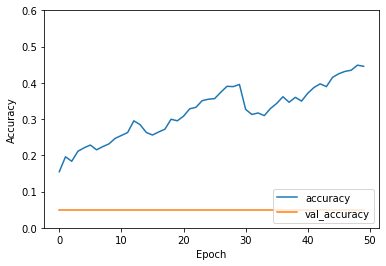

In [106]:
plt.plot(ResnetCoarsemodelHistory.history['accuracy'], label='accuracy')
plt.plot(ResnetCoarsemodelHistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.6])
plt.legend(loc='lower right')

In [108]:
test_loss, test_acc = ResnetCoarsemodel.evaluate(x_test,  y_test, verbose=2)

print(test_acc)

313/313 - 403s - loss: 4.4085 - accuracy: 0.0500
0.05000000074505806


In [109]:
predictionsResnetCoarsemodel=ResnetCoarsemodel.predict(test_images_reshaped)
print(predictionsResnetCoarsemodel)

[[0.01571625 0.22399314 0.02941566 ... 0.0164951  0.01175885 0.0378624 ]
 [0.01567853 0.22391762 0.02952113 ... 0.0164871  0.01175139 0.03779262]
 [0.01568515 0.22443788 0.02949302 ... 0.01648965 0.01174634 0.03779897]
 ...
 [0.01567763 0.22446308 0.02950623 ... 0.01647531 0.01174237 0.03770077]
 [0.01566969 0.22348714 0.0295664  ... 0.01647806 0.0117507  0.03774299]
 [0.01563889 0.22194743 0.02970349 ... 0.01650704 0.01176676 0.03784492]]


In [110]:
cm = confusion_matrix(np.array(test_labels), np.array(predictions), labels=np.unique(test_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot() 

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

# 

# 

# ResNet fine labels

In [65]:
import numpy as np
import tensorflow as tf
x_train = np.load('trnImage.npy')
y_train = np.load('trnLabel_fine.npy')
#labels_fine = np.load('trnLabel_fine.npy')

x_test = np.load('tstImage.npy')
y_test = np.load('tstLabel_fine.npy')
#test_labels_fine = np.load('tstLabel_fine.npy')

x_train = np.transpose(x_train, (3, 0, 1, 2))
x_test = np.transpose(x_test, (3, 0, 1, 2))
y_train = y_train.reshape(50000, 1)
y_test = y_test.reshape(10000, 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [66]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
ResnetFinemodel = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
ResnetFinemodel.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
ResnetFinemodel.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 32, 3)    12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 32, 32, 160)  4320        batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 32, 32, 160)  320         conv2d_80[0][0]                  
____________________________________________________________________________________________

In [67]:
ResnetFineModelHistory = ResnetFinemodel.fit(dataGenerator.flow(x_train, y_train, batch_size=50),
                              validation_data=(x_test, y_test),
                              epochs=50,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =50)

Epoch 1/50

 Start of Epoch Learning Rate = 0.100000
50/50 [==============================] - 399s 8s/step - loss: 7.9688 - accuracy: 0.0335 - val_loss: 405.1830 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.099406
Epoch 2/50

 Start of Epoch Learning Rate = 0.099406
50/50 [==============================] - 401s 8s/step - loss: 7.6146 - accuracy: 0.0589 - val_loss: 16.7258 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.042324
Epoch 3/50

 Start of Epoch Learning Rate = 0.100000
50/50 [==============================] - 404s 8s/step - loss: 7.3831 - accuracy: 0.0755 - val_loss: 12.2159 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.099851
Epoch 4/50

 Start of Epoch Learning Rate = 0.099851
50/50 [==============================] - 401s 8s/step - loss: 7.2517 - accuracy: 0.0828 - val_loss: 8.2260 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.082528
Epoch 5/50

 Start of Epoch Learning Rate = 0.082528
50/50 [==============================] - 401s 8s/st

50/50 [==============================] - 390s 8s/step - loss: 4.7237 - accuracy: 0.1991 - val_loss: 6.2369 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.091305
Epoch 38/50

 Start of Epoch Learning Rate = 0.091305
50/50 [==============================] - 390s 8s/step - loss: 4.6504 - accuracy: 0.2093 - val_loss: 6.8544 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.088344
Epoch 39/50

 Start of Epoch Learning Rate = 0.088344
50/50 [==============================] - 391s 8s/step - loss: 4.5429 - accuracy: 0.2112 - val_loss: 7.0144 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.085014
Epoch 40/50

 Start of Epoch Learning Rate = 0.085014
50/50 [==============================] - 393s 8s/step - loss: 4.5233 - accuracy: 0.2230 - val_loss: 6.3175 - val_accuracy: 0.0100

 End of Epoch Learning Rate = 0.081347
Epoch 41/50

 Start of Epoch Learning Rate = 0.081347
50/50 [==============================] - 391s 8s/step - loss: 4.4548 - accuracy: 0.2308 - val_loss: 6.22

In [69]:
ResnetFinemodel.save('resNet_fine_1')

INFO:tensorflow:Assets written to: resNet_fine_1\assets


plot training curves and test accuracy

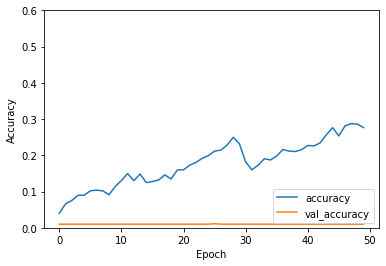

In [72]:
plt.plot(ResnetFineModelHistory.history['accuracy'], label='accuracy')
plt.plot(ResnetFineModelHistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.6])
plt.legend(loc='lower right')


In [73]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print(test_acc)

313/313 - 167s - loss: 65.3604 - accuracy: 0.0100
0.009999999776482582


In [70]:
predictionsResnetFinemodel=ResnetFinemodel.predict(test_images_reshaped)
print(predictionsResnetFinemodel)

[[0.01012157 0.01943859 0.0026361  ... 0.00429937 0.00563788 0.08619825]
 [0.01007977 0.01952694 0.00263482 ... 0.00430329 0.00563988 0.08634824]
 [0.01009737 0.01950925 0.00263198 ... 0.00430212 0.0056369  0.08633547]
 ...
 [0.01003984 0.01956393 0.00263371 ... 0.0043056  0.00563628 0.08633611]
 [0.01006966 0.01953766 0.00263495 ... 0.00430548 0.00564506 0.08650868]
 [0.01023299 0.01952851 0.00264168 ... 0.00430985 0.00565613 0.08607346]]


In [ ]:

cm = confusion_matrix(np.array(test_labels), np.array(predictions), labels=np.unique(test_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot() 

In [81]:
#change y_train from one-hot encoded
import numpy as np
y_rounded_labels=np.argmax(y_test, axis=1)
y_rounded_labels[1]
print(y_rounded_labels)

[49 33 72 ... 51 42 70]


In [89]:


cm = confusion_matrix(y_rounded_labels[0], predictionsResnetFinemodel[0], labels=np.unique(y_rounded_labels[0]))

#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_rounded_labels))
#disp.plot() 

TypeError: Singleton array 49 cannot be considered a valid collection.

In [97]:
print(np.array(y_rounded_labels))
print(np.array(predictionsResnetFinemodel))

print(type(y_rounded_labels))
print(type(predictionsResnetFinemodel))

[49 33 72 ... 51 42 70]
[[0.01012157 0.01943859 0.0026361  ... 0.00429937 0.00563788 0.08619825]
 [0.01007977 0.01952694 0.00263482 ... 0.00430329 0.00563988 0.08634824]
 [0.01009737 0.01950925 0.00263198 ... 0.00430212 0.0056369  0.08633547]
 ...
 [0.01003984 0.01956393 0.00263371 ... 0.0043056  0.00563628 0.08633611]
 [0.01006966 0.01953766 0.00263495 ... 0.00430548 0.00564506 0.08650868]
 [0.01023299 0.01952851 0.00264168 ... 0.00430985 0.00565613 0.08607346]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [94]:
from sklearn.metrics import confusion_matrix
y_true = np.array(y_rounded_labels)
y_pred = np.array(predictionsResnetFinemodel)
confusion_matrix(y_true, y_pred)



#, predictionsResnetFinemodel[0],

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
print("fini")